서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv```를 분석해보자.

파일은 웹 검색을 하고 다운로드해서 사용하면 된다.

데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.



|      date| count|

|----------|------|

|2018-01-01|  4950|

|2018-01-02|  7136|

|2018-01-03|  7156|

|2018-01-04|  7102|

|2018-01-05|  7705|

In [1]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [2]:
import os
myDf = spark\
        .read\
        .options(header='true', inferschema='true', delimiter=',')\
        .csv(os.path.join('data', '서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv'))
myDf = myDf.withColumnRenamed(myDf.columns[0], 'date')
myDf = myDf.withColumnRenamed(myDf.columns[1], 'count')

In [3]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

year = udf(lambda x: x[:4], StringType())
month =udf(lambda x: x[5:7], StringType())
yearAndMonth = udf(lambda x: x[:7], StringType())

myDf = myDf.withColumn("year", year(myDf['date']))
myDf = myDf.withColumn("year-month", yearAndMonth(myDf['date']))

### 문제 1-1: 년도별 대여건수 합계

데이터는 2018, 2019년 15개월 간의 대여건수이다. 년도별로 대여건수의 합계를 계산해서 출력하자.



|year|sum(count)|

|----|----------|

|2018|  10124874|

|2019|   1871935|

In [4]:
yearDf = myDf.select('year', 'count')
yearDf = yearDf.groupBy(yearDf['year']).sum()
yearDf = yearDf.orderBy(yearDf['year'], ascending=True)
yearDf.show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



### 문제 1-2: 년도별, 월별 대여건수 합계

년별, 월별로 대여건수를 계산하여 합계를 계산하여 출력한다.

In [5]:
ymDf = myDf.select('year-month', 'count')
ymDf = ymDf.groupBy(ymDf['year-month']).sum()
ymDf = ymDf.orderBy(ymDf['year-month'], ascending=True)
ymDf.show()

+----------+----------+
|year-month|sum(count)|
+----------+----------+
|   2018-01|    164367|
|   2018-02|    168741|
|   2018-03|    462661|
|   2018-04|    687885|
|   2018-05|    965609|
|   2018-06|   1207123|
|   2018-07|   1100015|
|   2018-08|   1037505|
|   2018-09|   1447993|
|   2018-10|   1420621|
|   2018-11|    961532|
|   2018-12|    500822|
|   2019-01|    495573|
|   2019-02|    471543|
|   2019-03|    904819|
+----------+----------+



### 문제 1-3: 년도별, 월별 대여건수 그래프

문제 1-2의 출력을 선 그래프로 그려보자.

In [6]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

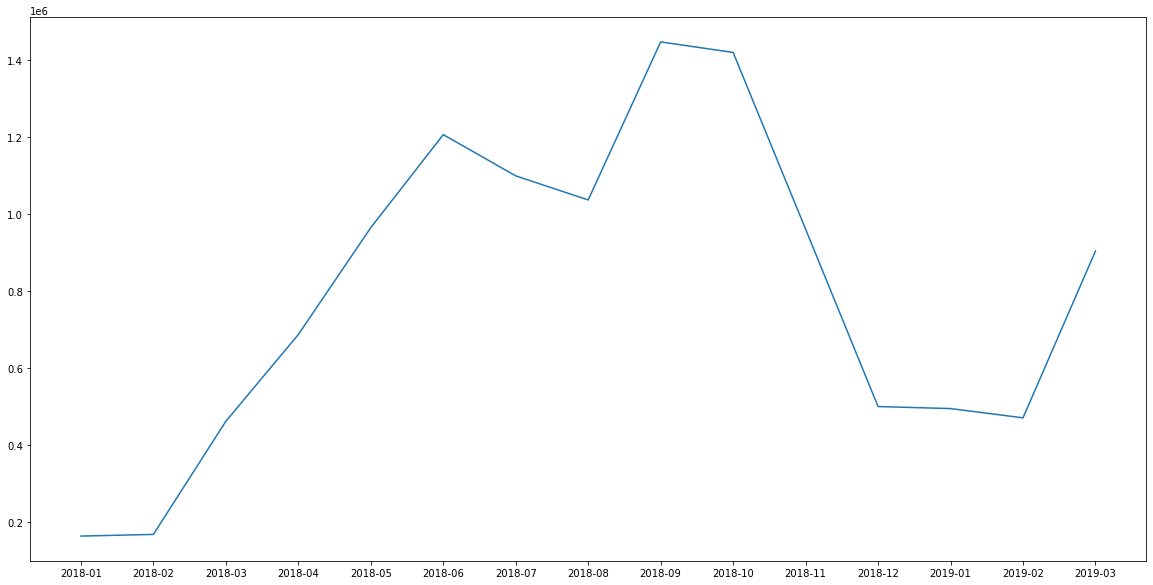

In [7]:
ym = ymDf.select('year-month', 'sum(count)').toPandas()
ym = ym.to_numpy()
x = list()
y = list()
for r in ym:
    x.append(r[0])
    y.append(r[1])
plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.show()

In [8]:
spark.stop()